In [1]:
import sys
sys.path.append('./../')
from pyNN.random import RandomDistribution, NumpyRNG
from pyNN import neuron
import pyNN.space as space
import pyNN
import pyNN.neuron as sim
import numpy as np
from pyNN.utility.plotting import Figure, Panel
from pyNN.space import Grid2D, RandomStructure, Sphere
import matplotlib.pyplot as plt
from neuroml import Morphology, Segment, Point3DWithDiam as P
from pyNN.morphology import NeuroMLMorphology, NeuriteDistribution, Morphology as Morph, IonChannelDistribution
from pyNN.neuron.morphology import uniform, random_section, random_placement, at_distances, apical_dendrites, dendrites, centre
from pyNN.parameters import IonicSpecies
from pyNN.standardmodels import StandardIonChannelModel, build_translations
from pyNN.neuron import NativeCellType
import shutil
import os
from neuron import h, hclass
from pyNN.utility.build import compile_nmodl
from pyNN.standardmodels.cells import MultiCompartmentNeuron as mc
import platform
import src.Classes as Classes
import src.functions as funçoes


numprocs=1
Loading NMODL files from /home/oj98yqyk/code/Modelo-Motoneuronio/Notebooks/../src
Copied muscle_unit_calcium
Copied mn
Copied muscle_unit
Copied gammapointprocess
Compiling NMODL files from /home/oj98yqyk/code/Modelo-Motoneuronio/Notebooks/../.venv/lib/python3.12/site-packages/pyNN/neuron/nmodl
nrnivmodl found at /home/oj98yqyk/code/Modelo-Motoneuronio/.venv/bin/nrnivmodl
Successfully compiled NEURON extensions.
Loading /home/oj98yqyk/code/Modelo-Motoneuronio/Notebooks/../.venv/lib/python3.12/site-packages/pyNN/neuron/nmodl/muscle_unit_calcium.o
Successfully loaded muscle_unit_calcium
Loading /home/oj98yqyk/code/Modelo-Motoneuronio/Notebooks/../.venv/lib/python3.12/site-packages/pyNN/neuron/nmodl/mn.o
Successfully loaded mn
Loading /home/oj98yqyk/code/Modelo-Motoneuronio/Notebooks/../.venv/lib/python3.12/site-packages/pyNN/neuron/nmodl/muscle_unit.o
Successfully loaded muscle_unit
Loading /home/oj98yqyk/code/Modelo-Motoneuronio/Notebooks/../.venv/lib/python3.12/site-packages

Configuração para os sistemas, compilação e carregamento de um arquivo de modelo (mn.mod) em um ambiente de simulação de redes neurais utilizando o pacote PyNN com o mecanismo de simulação NEURON

In [6]:
n = 100

somas = funçoes.create_somas(n)
dends = funçoes.create_dends(n,somas)

cell_type = Classes.cell_class(
    morphology= funçoes.soma_dend(somas, dends) ,
    cm=1,    # mF / cm**2
    Ra=0.070, # ohm.mm
    ionic_species={"na": IonicSpecies("na", reversal_potential=50),
                   "ks": IonicSpecies("ks", reversal_potential=-80),
                   "kf": IonicSpecies("kf", reversal_potential=-80)
                  },
    pas_soma = {"conductance_density": uniform('soma', 7e-4), "e_rev":-70},
    pas_dend = {"conductance_density": uniform('dendrite', 7e-4), "e_rev":-70},
    na = {"conductance_density": uniform('soma', 10), "vt":list(np.linspace(-57.65, -53,100))},
    kf = {"conductance_density": uniform('soma', 1), "vt":list(np.linspace(-57.65, -53,100))},
    ks = {"conductance_density": uniform('soma', 0.5), "vt":list(np.linspace(-57.65, -53,100))},

    syn={
        "locations": centre('dendrite'),
        "e_syn": 0,
        "tau_syn": 0.6},  
)


In [7]:
cells = sim.Population(n, cell_type, initial_values={'v': list(-70*np.ones(100))})


In [8]:
cells[0]._cell.synaptic_receptors

{'syn': defaultdict(list, {1: [ExpSyn[0]]})}

In [9]:
np.random.seed(26278342)
spike_source = sim.Population(400, sim.SpikeSourceArray(spike_times=funçoes.generate_spike_times))
syn = sim.StaticSynapse(weight=0.6, delay=0.2)
input_conns = sim.Projection(spike_source, cells, 
                             sim.FixedProbabilityConnector(0.3, location_selector='dendrite'), 
                             syn, receptor_type="syn")

In [10]:
spike_source

Population(400, SpikeSourceArray(<parameters>), structure=Line(dx=1.0, x0=0.0, y=0.0, z=0.0), label='population1')

In [11]:
step_current_dend = sim.DCSource(amplitude=7000, start=0, stop=50)
#step_current.inject_into(cells[1:2], location=apical_dendrites(fraction_along=0.9))
#step_current.inject_into(cells[1:2], location=random(after_branch_point(3)(apical_dendrites))
# step_current_dend.inject_into(cells[0:2], location='dendrite')

In [12]:
spike_source.record('spikes')
cells.record('spikes')
cells[0:2].record('v', locations=('dendrite','soma'))
cells[0:2].record(('na.m', 'na.h'), locations='soma')
cells[0:2].record(('kf.n'), locations='soma')
cells[0:2].record(('ks.p'), locations='soma')


In [13]:
sim.run(100)

100.00000000001417

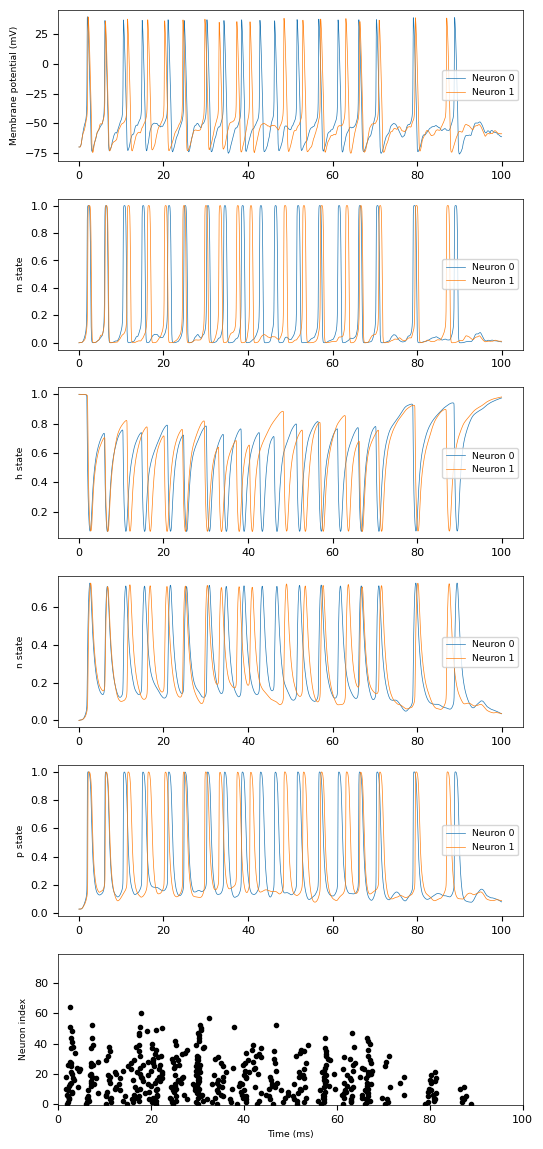

In [14]:
figure_filename = 'teste.png'

data = cells.get_data().segments[0]
vm = data.filter(name="soma.v")[0]
m = data.filter(name="soma.na.m")[0]
h = data.filter(name="soma.na.h")[0]
n = data.filter(name="soma.kf.n")[0]
p = data.filter(name="soma.ks.p")[0]
# ina = data.filter(name="soma.na.ina")[0]
# ik = data.filter(name="ik")[0]

# gsyn = data.filter(name="gsyn_exc")[0]
Figure(
    Panel(vm, ylabel="Membrane potential (mV)", xticks=True, yticks=True),
    Panel(m, ylabel="m state", xticks=True, yticks=True),
    Panel(h, ylabel="h state", xticks=True, yticks=True),
    Panel(n, ylabel="n state", xticks=True, yticks=True),
    Panel(p, ylabel="p state", xticks=True, yticks=True),
    # Panel(ina, ylabel="i_na (mA)", xticks=True, yticks=True),
    # Panel(ik, ylabel="i_k (mA)", xticks=True, yticks=True),

    # Panel(gsyn, ylabel="Synaptic conductance (uS)"),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
).save(figure_filename)


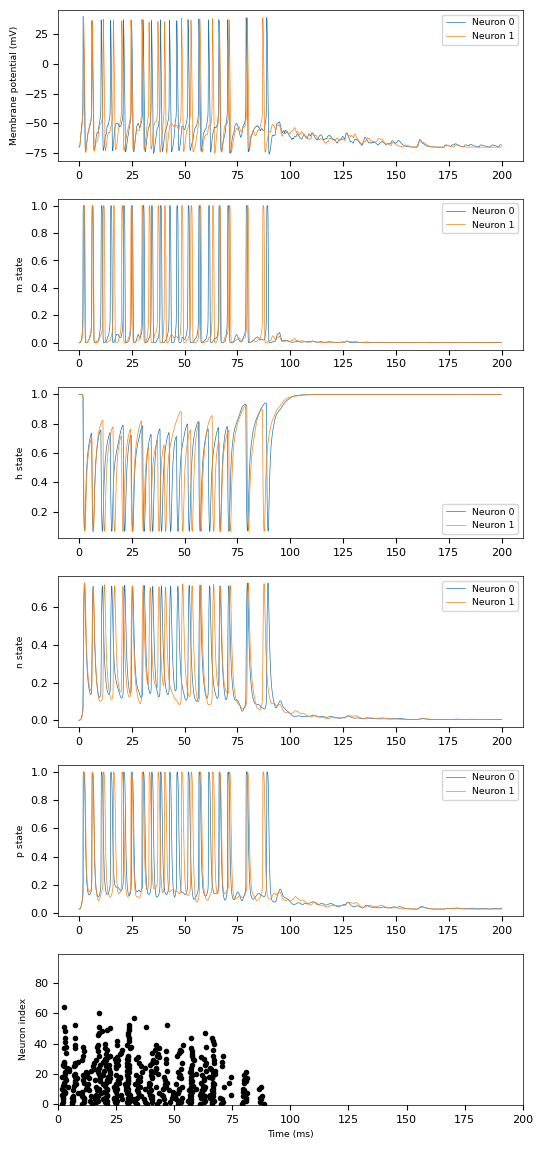

In [15]:
sim.run(100)
figure_filename = 'teste.png'

data = cells.get_data().segments[0]
vm = data.filter(name="soma.v")[0]
m = data.filter(name="soma.na.m")[0]
h = data.filter(name="soma.na.h")[0]
n = data.filter(name="soma.kf.n")[0]
p = data.filter(name="soma.ks.p")[0]
# ina = data.filter(name="soma.na.ina")[0]
# ik = data.filter(name="ik")[0]

# gsyn = data.filter(name="gsyn_exc")[0]
Figure(
    Panel(vm, ylabel="Membrane potential (mV)", xticks=True, yticks=True),
    Panel(m, ylabel="m state", xticks=True, yticks=True),
    Panel(h, ylabel="h state", xticks=True, yticks=True),
    Panel(n, ylabel="n state", xticks=True, yticks=True),
    Panel(p, ylabel="p state", xticks=True, yticks=True),
    # Panel(ina, ylabel="i_na (mA)", xticks=True, yticks=True),
    # Panel(ik, ylabel="i_k (mA)", xticks=True, yticks=True),

    # Panel(gsyn, ylabel="Synaptic conductance (uS)"),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
).save(figure_filename)
